In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from joblib import Parallel, delayed, parallel_backend
# from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_V_A_change_added_noise_fn, up_RTs_fit_OPTIM_V_A_change_added_noise_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_fn, PA_with_LEDON_2
from psiam_tied_dv_map_utils_with_PDFs import up_RTs_fit_OPTIM_V_A_change_gamma_omega_fn, down_RTs_fit_OPTIM_V_A_change_gamma_omega_fn
import pandas as pd
import random
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz
from pyvbmc import VBMC
import corner
from diagnostics_class import Diagnostics
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_fn, CDF_RT_fn
from scipy.integrate import cumulative_trapezoid as cumtrapz
import pickle
from single_cond_utils import PA_with_LEDON_2_VEC
from psiam_tied_dv_map_utils_with_PDFs import up_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_fn
from psiam_tied_dv_map_utils_with_PDFs import down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_fn
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_fn

import io
import matplotlib.gridspec as gridspec
import corner

In [2]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


In [3]:
# LED OFF
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')

# valid trials
df_led_off_valid_trials = df_led_off[df_led_off['success'].isin([1,-1])]
print(f'len of led off valid trials = {len(df_led_off_valid_trials)}')

# remove trials with RT > 1s
df_led_off_valid_trials = df_led_off_valid_trials[df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix'] < 1]
print(f'len of valid trials < 1s : {len(df_led_off_valid_trials)}')

len of LED off: 66226
len of led off valid trials = 53472
len of valid trials < 1s : 52799


In [4]:
ABL = 20; ILD = 1
df_led_off_valid_trials_case = df_led_off_valid_trials[
    (df_led_off_valid_trials['ABL'] == ABL) &
    (df_led_off_valid_trials['ILD'] == ILD)
]

print(f'len of df_led_off_valid_trials_case = {len(df_led_off_valid_trials_case)}')

len of df_led_off_valid_trials_case = 1688


In [5]:
def K0(y, h, a, b):
    # a*sin(2*pi/h*(y-b)) where (y-b)>=0 and (y-b)<h/4, else 0
    return a * np.sin(2 * np.pi/h * (y - b)) * ((y - b) >= 0) * ((y - b) < h/4)

def K1(y, h, a, b):
    # (1+a*sin(2*pi/h*(y-b))) for (y-b) in [h/4, h/2)
    return (1 + a * np.sin(2 * np.pi/h * (y - b))) * ((y - b) >= h/4) * ((y - b) < h/2)

def K2(y, h, a, b):
    # (1 - a*(y-b)/h * exp(1 - (y-b)/h)) for (y-b)>=0
    return (1 - a * (y - b) / h * np.exp(1 - (y - b)/h)) * ((y - b) >= 0)

def phi_fn(y, h1, a1, b1, h2, a2):
    # Combination of K0, K1, and K2 functions
    return K0(y, h1, 1 + a1, b1) + K1(y, h1, a1, b1) + K2(y, h2, a2, b1 + h1/2)

def I0(y, h, a, b):
    # a*h/pi * sin(pi/h*(y-b))^2 for (y-b)>=0 and (y-b)<=h/4
    return a * h/np.pi * (np.sin(np.pi/h * (y - b))**2) * ((y - b) >= 0) * ((y - b) <= h/4)

def I1(y, h, a, b):
    # I0 evaluated at b+h/4 plus extra terms for y in (b+h/4, b+h/2]
    term1 = I0(b + h/4, h, 1 + a, b)
    term2 = y - (b + h/4)
    term3 = a * h/(2 * np.pi) * np.cos(2 * np.pi/h * (y - b))
    return (term1 + term2 - term3) * ((y - b) > h/4) * ((y - b) <= h/2)

def I2(y, h1, a1, b1, h2, a2, b2):
    # I1 evaluated at b2 plus extra terms for y > b2
    term1 = I1(b2, h1, a1, b1)
    term2 = y - b2
    # The expression: -a2*h2*(-exp(1-(y-b2)/h2).*((y-b2)/h2+1)+exp(1))
    term3 = a2 * h2 * (-np.exp(1 - (y - b2)/h2) * ((y - b2)/h2 + 1) + np.exp(1))
    return (term1 + term2 - term3) * ((y - b2) > 0)

def int_phi(y, h1, a1, b1, h2, a2):
    # Combination of I0, I1, and I2 functions with b2 = b1+h1/2
    b2 = b1 + h1/2
    return I0(y, h1, 1 + a1, b1) + I1(y, h1, a1, b1) + I2(y, h1, a1, b1, h2, a2, b2)



Text(0.5, 1.0, 'int phi t')

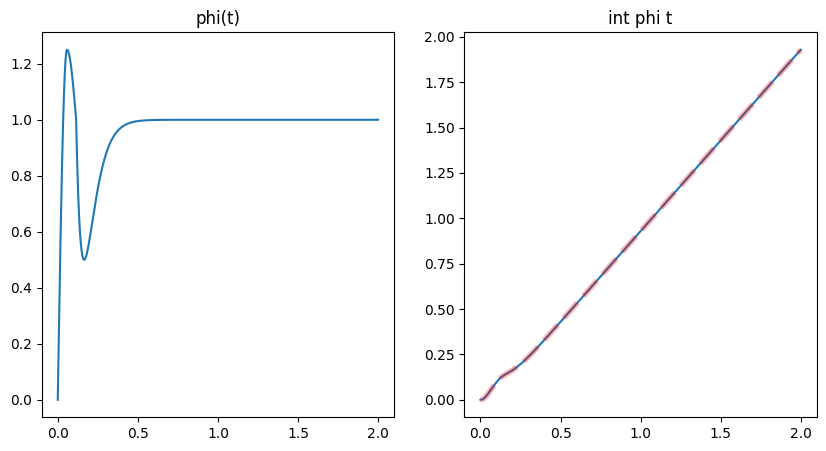

In [6]:
bump_width = 0.23   # h1
bump_height = 0.25  # a1
bump_offset = 0     # b1
dip_width = 0.05    # h2
dip_height = 0.5    # a2

# Example usage with a NumPy array for y
import numpy as np
y = np.arange(0, 2, 0.001)  # example y values

phi_vals = phi_fn(y, bump_width, bump_height, bump_offset, dip_width, dip_height)
int_phi_vals = int_phi(y, bump_width, bump_height, bump_offset, dip_width, dip_height)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(y, phi_vals);
plt.title('phi(t)')

plt.subplot(1,2,2)
plt.plot(y, int_phi_vals)
# numerical 
num_int_phi = cumtrapz(phi_vals, y, initial=0)
plt.plot(y, num_int_phi, ls='--', color='r', alpha=0.3, lw=4)
plt.title('int phi t')


In [7]:
df_up = df_led_off_valid_trials_case[df_led_off_valid_trials_case['choice'] == 1]
df_down = df_led_off_valid_trials_case[df_led_off_valid_trials_case['choice'] == -1]

In [8]:
rt_up = df_up['timed_fix'] - df_up['intended_fix']
rt_down = df_down['timed_fix'] - df_down['intended_fix']

In [9]:
bins = np.arange(0, 1, 0.02)

rt_up_hist, _ = np.histogram(rt_up, bins=bins, density=True)
rt_down_hist, _ = np.histogram(rt_down, bins=bins, density=True)

frac_up = len(rt_up) / len(df_led_off_valid_trials_case)
frac_down = len(rt_down) / len(df_led_off_valid_trials_case)

In [10]:
####################### theory #######################
from single_cond_utils import PA_with_LEDON_2_VEC
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A # LED OFF

# delays
t_A_aff = -0.187
del_go = 0.13 


N_theory = int(1e3)
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(0, 2, 0.001)

P_A_samples = np.zeros((N_theory, len(t_pts)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    pdf = PA_with_LEDON_2_VEC(t_pts, V_A, V_A_post_LED, theta_A, t_stim, t_LED, t_A_aff)
    P_A_samples[idx, :] = pdf


P_A_samples_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

In [11]:
# 
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn

0.6437851800976914 0.6273696682464455
0.3557605169058546 0.3726303317535545
0.9995456970035459


Text(0.5, 1.0, 't_E_aff=0.3, b1 = 0, area=1.00')

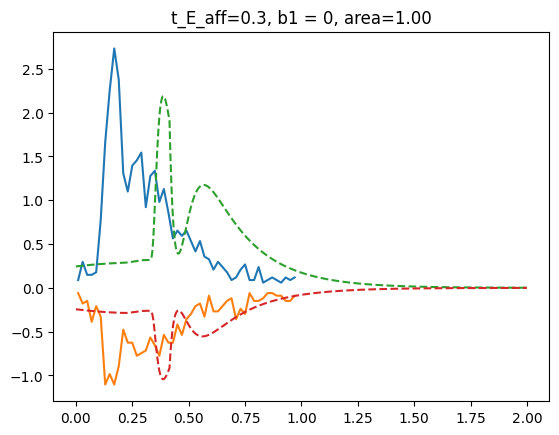

In [18]:
from types import SimpleNamespace

## Temp params - eye fit juan 
gamma  = 0.43
omega = 3.1543
t_E_aff = 0.3

bump_width = 0.23
bump_height = 0.25
bump_offset = 0
dip_width = 0.038857
dip_height = 0.9


phi_params =  {
    'h1': bump_width,
    'a1': bump_height,
    'b1': bump_offset,
    'h2': dip_width,
    'a2': dip_height
}
phi_params_obj = SimpleNamespace(**phi_params)

K_max = 10
up_wrt_stim = np.zeros_like(t_pts)
down_wrt_stim = np.zeros_like(t_pts)
for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    up_wrt_stim[idx] =  up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, phi_params_obj, 1, K_max)
    down_wrt_stim[idx] = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, phi_params_obj, -1, K_max)

theory_area_up = trapz(up_wrt_stim, t_pts)
theory_area_down = trapz(down_wrt_stim, t_pts)

print(theory_area_up, frac_up)
print(theory_area_down, frac_down)
print(theory_area_up + theory_area_down)
total_area = theory_area_up + theory_area_down

bin_centers = 0.5*(bins[1:] + bins[:-1])

plt.plot(bin_centers, rt_up_hist * frac_up)
plt.plot(bin_centers, -rt_down_hist * frac_down)

plt.plot(t_pts, up_wrt_stim, ls='--')
plt.plot(t_pts, -down_wrt_stim, ls='--')
plt.title(f'ABL = {ABL}, ILD = {ILD}')
plt.title(f't_E_aff={t_E_aff}, b1 = {phi_params_obj.b1}, area={total_area :.2f}')


In [ ]:
plt.plot(t_pts,up_wrt_stim + down_wrt_stim )
plt.hist(df_led_off_valid_trials_case['timed_fix']-df_led_off_valid_trials_case['intended_fix'], \
         bins=np.arange(0,1,0.01), density=True, histtype='step')
plt.axvline(t_E_aff, color='k', alpha=0.3, label='del E')
plt.legend()
plt.title(f'del E = {t_E_aff}. up + down')

In [ ]:
plt.plot(t_pts, P_A_samples_mean, label='proactive')
plt.plot(t_pts, up_wrt_stim, color='g', label='up')
plt.plot(t_pts, down_wrt_stim, color='r', label='down')
plt.plot(t_pts, up_wrt_stim + down_wrt_stim, color='k', label='up+down', ls='--')
plt.ylim(0, 0.6)
plt.axvline(t_E_aff, alpha=0.3, label='del E')
plt.legend()
plt.xlabel('RT')
plt.ylabel('density')
plt.title(f'del E = {t_E_aff}')

# vbmc

## loglike fn

In [ ]:
def compute_loglike_trial(row, gamma, omega, t_E_aff, h1, a1, h2, a2):
    # data
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']

    response_poke = row['response_poke']

    phi_params = {'h1': h1, 'a1': a1, 'h2': h2, 'a2': a2, 'b1': 0 }
    phi_params_obj = SimpleNamespace(**phi_params)

    t_pts_1 = np.arange(t_stim, t_stim + 1, 0.001)
    P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts_1])
    area_btn_stim_and_1s = trapz(P_A_LED_change, t_pts_1)
    trunc_factor_p_joint = area_btn_stim_and_1s
        
    # PA and CA
    P_A = PA_with_LEDON_2(rt, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff)
    t_pts_2 = np.arange(0, t, 0.001)
    P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts_2])
    C_A = trapz(P_A_LED_change, t_pts_2)

    if response_poke == 3:
        # up
        P_joint_rt_choice =     up_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(
                                        rt, P_A, C_A, gamma, omega, t_E_aff, del_go, phi_params_obj, K_max
                                        )
    elif response_poke == 2:
        # down
        P_joint_rt_choice = down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(
                                        rt, P_A, C_A, gamma, omega, t_E_aff, del_go, phi_params_obj, K_max
                                        )
    

    
    P_joint_rt_choice_trunc = max(P_joint_rt_choice / (trunc_factor_p_joint + 1e-10), 1e-10)
    
    wt_log_like = np.log(P_joint_rt_choice_trunc)

    if np.isnan(wt_log_like):
        return np.log(1e-50)

    return wt_log_like


def vbmc_loglike_fn(params):
    gamma, omega, t_E_aff, h1, a1, h2, a2 = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike_trial)(row, gamma, omega, t_E_aff, h1, a1, h2, a2) \
                                     for _, row in df_led_off_valid_trials_case.iterrows())
    
    return np.sum(all_loglike)

In [ ]:
gamma_bounds = [0.02, 2]
gamma_plausible_bounds = [0.09, 0.9]

omega_bounds = [0.05, 50]
omega_plausible_bounds = [0.5, 10]

t_E_aff_bounds = [0, 1]
t_E_aff_plausible_bounds = [0.01, 0.2]

# bump_width = 0.23   # h1
# bump_height = 0.25  # a1
# bump_offset = 0     # b1
# dip_width = 0.05    # h2
# dip_height = 0.5    # a2

h1_bounds = [0.001, 1]
h1_plausible_bounds = [0.02, 0.7]

a1_bounds = [0.001, 1]
a1_plausible_bounds = [0.02, 0.7]

h2_bounds = [0.001, 0.9]
h2_plausible_bounds = [0.02, 0.09]

a2_bounds = [0.001, 5]
a2_plausible_bounds = [0.1, 0.9]

In [ ]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    gamma, omega, t_E_aff, h1, a1, h2, a2 = params
    gamma_logpdf = trapezoidal_logpdf(gamma, gamma_bounds[0], gamma_plausible_bounds[0], gamma_plausible_bounds[1], gamma_bounds[1])
    omega_logpdf = trapezoidal_logpdf(omega, omega_bounds[0], omega_plausible_bounds[0], omega_plausible_bounds[1], omega_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    h1_logpdf = trapezoidal_logpdf(h1, h1_bounds[0], h1_plausible_bounds[0], h1_plausible_bounds[1], h1_bounds[1])
    a1_logpdf = trapezoidal_logpdf(a1, a1_bounds[0], a1_plausible_bounds[0], a1_plausible_bounds[1], a1_bounds[1])
    h2_logpdf = trapezoidal_logpdf(h2, h2_bounds[0], h2_plausible_bounds[0], h2_plausible_bounds[1], h2_bounds[1])
    a2_logpdf = trapezoidal_logpdf(a2, a2_bounds[0], a2_plausible_bounds[0], a2_plausible_bounds[1], a2_bounds[1])
    return gamma_logpdf + omega_logpdf + t_E_aff_logpdf + h1_logpdf + a1_logpdf + h2_logpdf + a2_logpdf

In [ ]:
def vbmc_joint_fn(params):
    priors = vbmc_prior_fn(params)
    loglike = vbmc_loglike_fn(params)

    return priors + loglike

In [ ]:
# Create bounds arrays
lb = np.array([
    gamma_bounds[0], omega_bounds[0], t_E_aff_bounds[0],
    h1_bounds[0], a1_bounds[0], h2_bounds[0], a2_bounds[0]
])
ub = np.array([
    gamma_bounds[1], omega_bounds[1], t_E_aff_bounds[1],
    h1_bounds[1], a1_bounds[1], h2_bounds[1], a2_bounds[1]
])

plb = np.array([
    gamma_plausible_bounds[0], omega_plausible_bounds[0], t_E_aff_plausible_bounds[0],
    h1_plausible_bounds[0], a1_plausible_bounds[0], h2_plausible_bounds[0], a2_plausible_bounds[0]
])
pub = np.array([
    gamma_plausible_bounds[1], omega_plausible_bounds[1], t_E_aff_plausible_bounds[1],
    h1_plausible_bounds[1], a1_plausible_bounds[1], h2_plausible_bounds[1], a2_plausible_bounds[1]
])

# Initialize with random values within plausible bounds
np.random.seed(42)
gamma_0 = np.random.uniform(*gamma_plausible_bounds)
omega_0 = np.random.uniform(*omega_plausible_bounds)
t_E_aff_0 = np.random.uniform(*t_E_aff_plausible_bounds)
h1_0 = np.random.uniform(*h1_plausible_bounds)
a1_0 = np.random.uniform(*a1_plausible_bounds)
h2_0 = np.random.uniform(*h2_plausible_bounds)
a2_0 = np.random.uniform(*a2_plausible_bounds)

x_0 = np.array([gamma_0, omega_0, t_E_aff_0, h1_0, a1_0, h2_0, a2_0])

In [ ]:
vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

In [ ]:
# Draw samples from the variational posterior
vp_samples = vp.sample(int(1e5))[0]

# Extract individual parameter samples
gamma_samples = vp_samples[:, 0]
omega_samples = vp_samples[:, 1]
t_E_aff_samples = vp_samples[:, 2]
h1_samples = vp_samples[:, 3]
a1_samples = vp_samples[:, 4]
h2_samples = vp_samples[:, 5]
a2_samples = vp_samples[:, 6]

# Compute posterior means
gamma = gamma_samples.mean()
omega = omega_samples.mean()
t_E_aff = t_E_aff_samples.mean()
h1 = h1_samples.mean()
a1 = a1_samples.mean()
h2 = h2_samples.mean()
a2 = a2_samples.mean()

# Stack all parameters for the corner plot
corner_samples = np.vstack([
    gamma_samples, omega_samples, t_E_aff_samples,
    h1_samples, a1_samples, h2_samples, a2_samples
]).T

# Compute ranges for plotting
percentiles = np.percentile(corner_samples, [0, 100], axis=0)
_ranges = [(percentiles[0, i], percentiles[1, i]) for i in range(corner_samples.shape[1])]

# Parameter labels
param_labels = ['gamma', 'omega', 't_E_aff', 'h1', 'a1', 'h2', 'a2']

# Plot the corner plot
corner.corner(
    corner_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".4f"
);
